In [ ]:
# pip install plotly

In [3]:
# 1) 라이브러리 임포트 및 기본 설정
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models, optimizers, callbacks
from datetime import datetime, timedelta

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

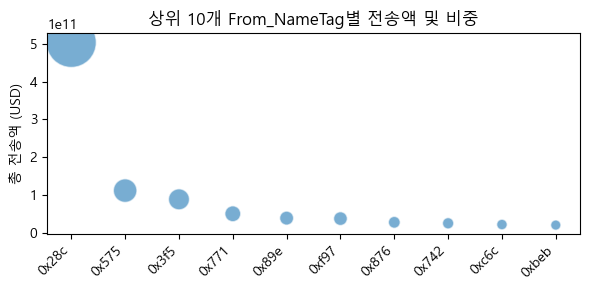

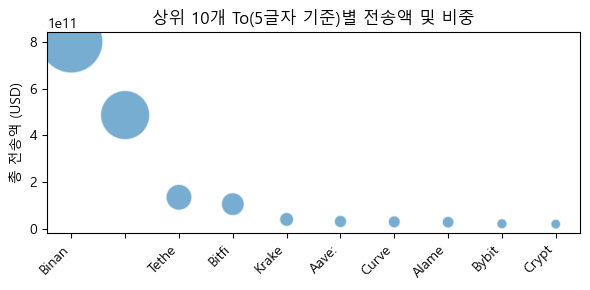

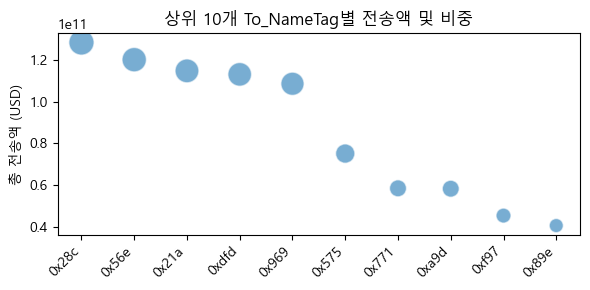

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

file_path = '../onchain/usdt_onchain.csv'  # 실제 경로에 맞춰 수정

# 1) CSV 읽기 (gzip / utf-8 시도 → 실패 시 latin1)
try:
    df = pd.read_csv(file_path, compression='gzip', encoding='utf-8')
except (OSError, UnicodeDecodeError):
    df = pd.read_csv(file_path, encoding='latin1')

# 2) 컬럼명 앞뒤 공백 제거
df.columns = df.columns.str.strip()

# 3) ValueUSD 전처리: "$","," 제거 후 숫자형으로 변환
df['ValueUSD'] = (
    df['Value (USD)']
    .astype(str)
    .str.replace(r'[\$,]', '', regex=True)
    .pipe(pd.to_numeric, errors='coerce')
)

# 4) Date 컬럼을 datetime 형으로 변환
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# 5) 필요한 컬럼만 추출
df = df[['Date', 'From_NameTag', 'To', 'To_NameTag', 'Amount', 'ValueUSD']].dropna(subset=['Date', 'ValueUSD'])

# 함수: 지정된 컬럼별 상위 10개 버블맵 그리기
def plot_bubble(df, group_col, title):
    grouped = (
        df.groupby(group_col)
          .agg(total_value=('ValueUSD', 'sum'))
          .reset_index()
    )
    grouped['proportion'] = grouped['total_value'] / grouped['total_value'].sum()
    top10 = grouped.sort_values('total_value', ascending=False).head(10).reset_index(drop=True)
    top10['short_name'] = top10[group_col].astype(str).str.slice(0, 5)

    plt.figure(figsize=(6, 3))
    x = range(len(top10))
    y = top10['total_value']
    sizes = top10['proportion'] * 5000

    plt.scatter(x, y, s=sizes, alpha=0.6, edgecolors='w')
    plt.xticks(x, top10['short_name'], rotation=45, ha='right')
    plt.ylabel('총 전송액 (USD)')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 6) From_NameTag 기준 버블맵
plot_bubble(df, 'From_NameTag', '상위 10개 From_NameTag별 전송액 및 비중')

# 7) To 기준 버블맵
df['To_prefix5'] = df['To'].str.slice(0, 5)
plot_bubble(df, 'To_prefix5', '상위 10개 To(5글자 기준)별 전송액 및 비중')

# 8) To_NameTag 기준 버블맵
plot_bubble(df, 'To_NameTag', '상위 10개 To_NameTag별 전송액 및 비중')


                                Date      ValueUSD
count                          46375  4.637500e+04
mean   2023-03-11 13:53:45.367115776  4.197627e+07
min              2020-01-03 00:00:00  1.600000e+07
25%              2021-10-28 00:00:00  2.000000e+07
50%              2023-03-16 00:00:00  2.685388e+07
75%              2024-09-02 00:00:00  4.626160e+07
max              2025-04-30 00:00:00  9.999999e+08
std                              NaN  5.165610e+07


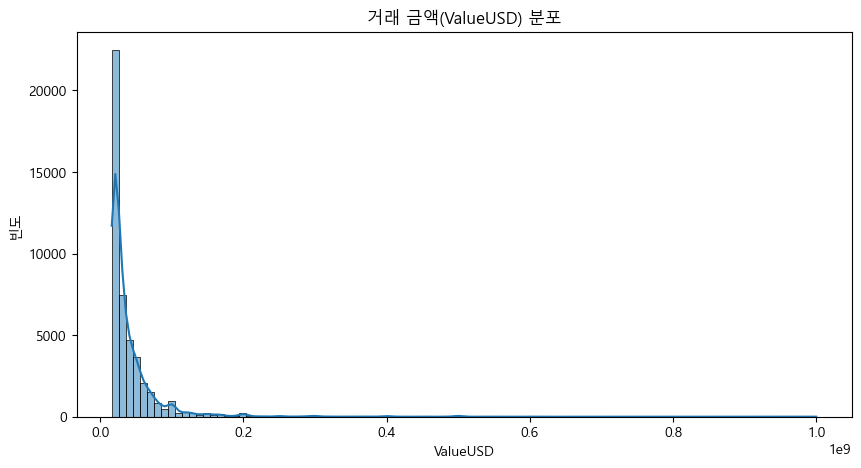

NameError: name 'daily_agg' is not defined

<Figure size 1200x600 with 0 Axes>

In [9]:
# 3) 탐색적 데이터 분석(EDA): 기초 통계 및 시각화

# 3-1) 기초 통계 출력
print(df.describe())

# 3-2) 거래 금액(ValueUSD) 분포 히스토그램 (seaborn 사용)
plt.figure(figsize=(10, 5))
sns.histplot(df['ValueUSD'].dropna(), bins=100, kde=True)
plt.title('거래 금액(ValueUSD) 분포')
plt.xlabel('ValueUSD')
plt.ylabel('빈도')
plt.show()

# 3-4) 날짜별 총 거래 금액 시각화 (seaborn 사용)
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_agg, x='Date', y='daily_sum')
plt.title('날짜별 총 거래 금액')
plt.xlabel('Date')
plt.ylabel('Daily Sum of ValueUSD')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3-5) 날짜별 거래 건수 시각화 (seaborn 사용)
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_agg, x='Date', y='daily_count')
plt.title('날짜별 거래 건수')
plt.xlabel('Date')
plt.ylabel('Daily Transaction Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

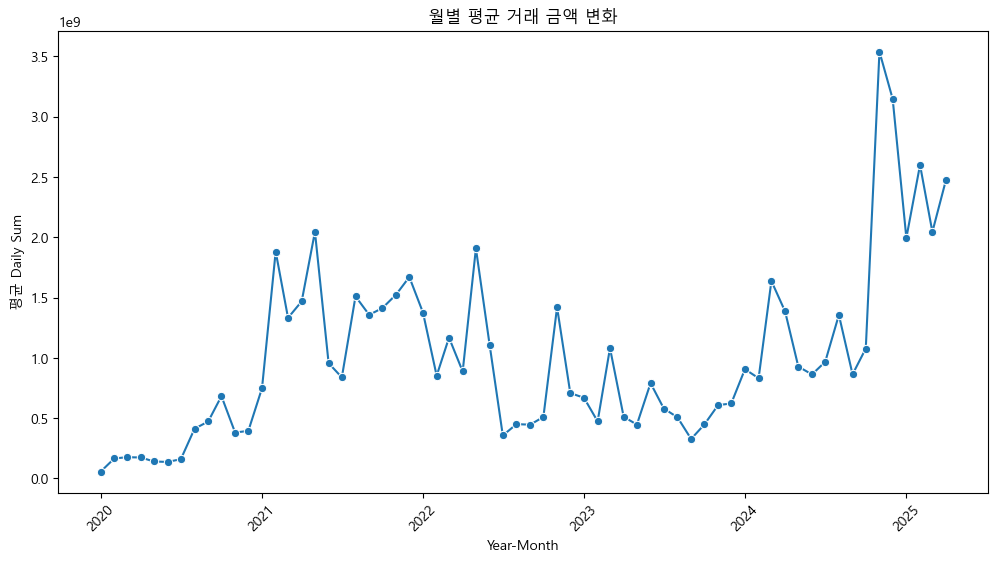

In [70]:
# 10) 필요 시 추가 시각화 예시: 월별 평균 거래 금액 변화

# 10-1) 월별로 집계
series_month = daily_agg.copy()
series_month['YearMonth'] = series_month['Date'].dt.to_period('M')
monthly_avg = series_month.groupby('YearMonth')['daily_sum'].mean().reset_index()
monthly_avg['YearMonth'] = monthly_avg['YearMonth'].dt.to_timestamp()

# 10-2) 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_avg, x='YearMonth', y='daily_sum', marker='o')
plt.title('월별 평균 거래 금액 변화')
plt.xlabel('Year-Month')
plt.ylabel('평균 Daily Sum')
plt.xticks(rotation=45)
plt.show()


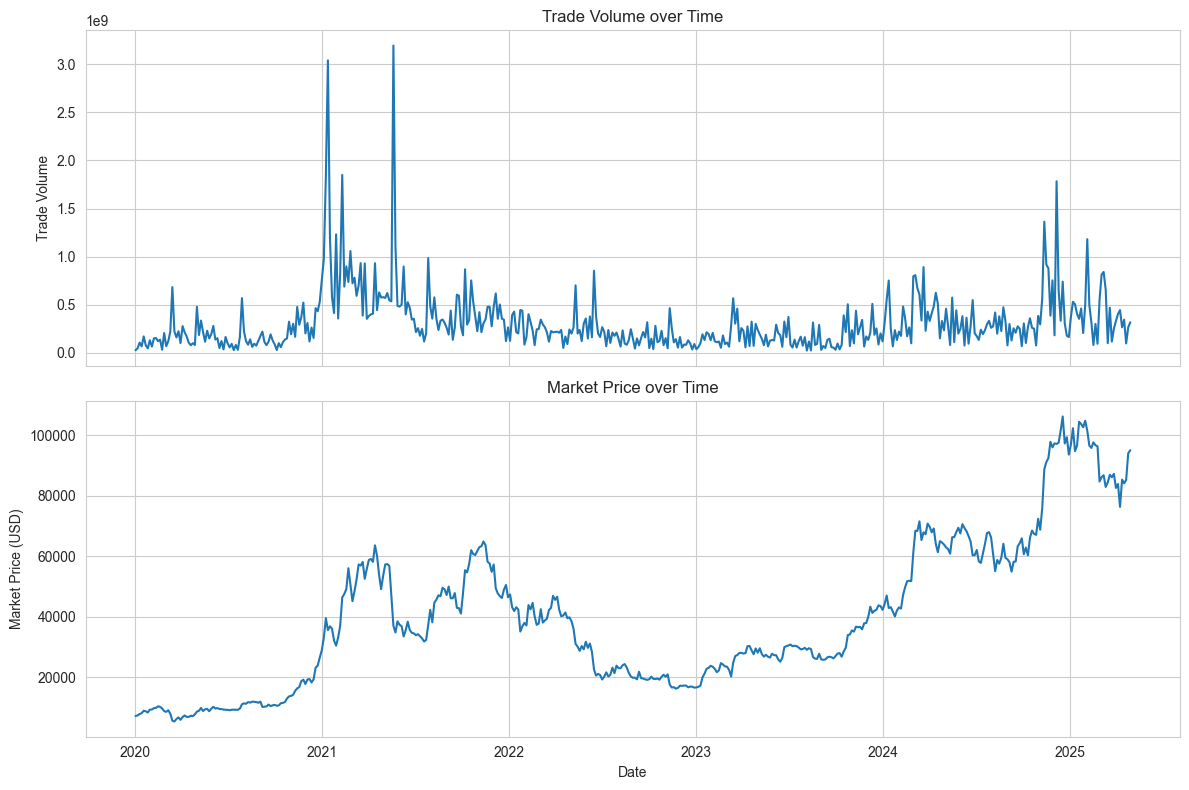

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) JSON 파일 로드
with open('./onchain/trade-volume.json', 'r') as f:
    data = json.load(f)

# 2) pandas DataFrame으로 변환
df_tv = pd.DataFrame(data['trade-volume'])      # trade-volume 배열
df_mp = pd.DataFrame(data['market-price'])      # market-price 배열

# 3) timestamp(ms)를 datetime으로 변환
df_tv['date'] = pd.to_datetime(df_tv['x'], unit='ms')
df_mp['date'] = pd.to_datetime(df_mp['x'], unit='ms')

# 4) 컬럼 이름 정리
df_tv = df_tv.rename(columns={'y': 'trade_volume'})[['date', 'trade_volume']]
df_mp = df_mp.rename(columns={'y': 'market_price'})[['date', 'market_price']]

# 5) 시각화 세팅
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 6) 첫 번째 서브플롯: trade-volume
sns.lineplot(
    ax=axes[0],
    data=df_tv,
    x='date',
    y='trade_volume'
)
axes[0].set_title('Trade Volume over Time')
axes[0].set_ylabel('Trade Volume')

# 7) 두 번째 서브플롯: market-price
sns.lineplot(
    ax=axes[1],
    data=df_mp,
    x='date',
    y='market_price'
)
axes[1].set_title('Market Price over Time')
axes[1].set_ylabel('Market Price (USD)')
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.show()


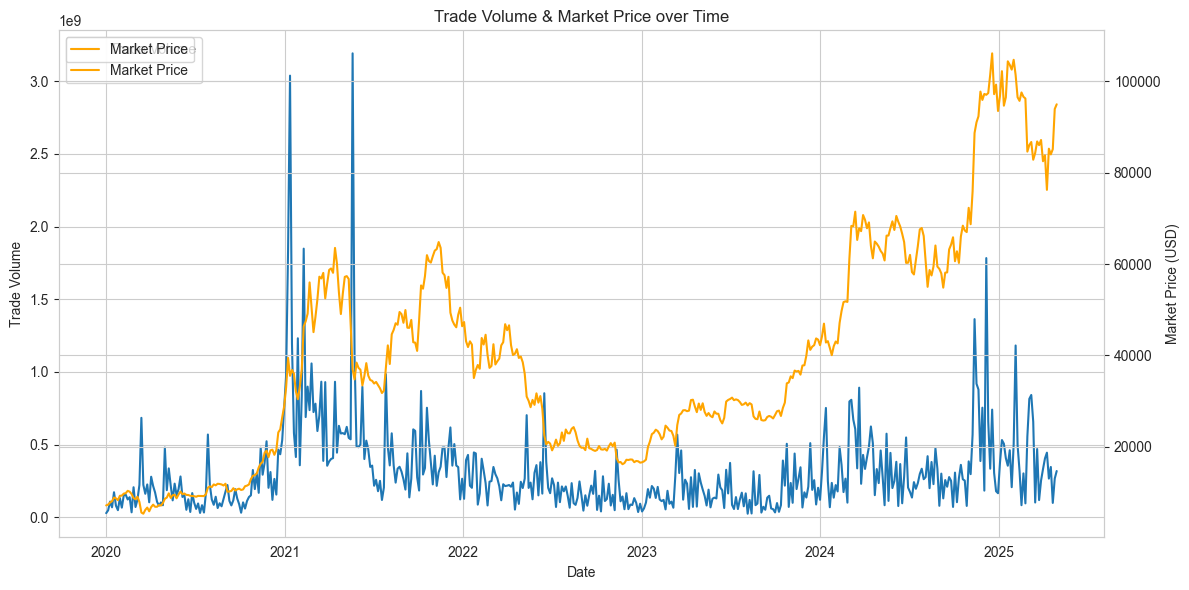

In [5]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) JSON 파일 로드
with open('./onchain/trade-volume.json', 'r') as f:
    data = json.load(f)

# 2) pandas DataFrame으로 변환
df_tv = pd.DataFrame(data['trade-volume'])      # trade-volume 배열
df_mp = pd.DataFrame(data['market-price'])      # market-price 배열

# 3) timestamp(ms)를 datetime으로 변환
df_tv['date'] = pd.to_datetime(df_tv['x'], unit='ms')
df_mp['date'] = pd.to_datetime(df_mp['x'], unit='ms')

# 4) 컬럼 이름 정리
df_tv = df_tv.rename(columns={'y': 'trade_volume'})[['date', 'trade_volume']]
df_mp = df_mp.rename(columns={'y': 'market_price'})[['date', 'market_price']]

# (선택) 날짜 기준으로 합치고 싶으면 이렇게:
# df = pd.merge(df_tv, df_mp, on='date', how='inner')

# 5) 한 축에 두 개 겹쳐 그리기 (y축이 다를 경우 twinx)
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(12, 6))

# 6) 첫 번째 시계열: trade_volume
sns.lineplot(
    ax=ax1,
    data=df_tv,
    x='date',
    y='trade_volume',
    label='Trade Volume'
)
ax1.set_ylabel('Trade Volume')
ax1.set_xlabel('Date')

# 7) 두 번째 시계열: market_price (y축 스케일이 다르므로 twinx 사용)
ax2 = ax1.twinx()
sns.lineplot(
    ax=ax2,
    data=df_mp,
    x='date',
    y='market_price',
    label='Market Price',
    color='orange'
)
ax2.set_ylabel('Market Price (USD)')

# 8) 범례 합치기
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# 9) 제목
ax1.set_title('Trade Volume & Market Price over Time')

plt.tight_layout()
plt.show()
